# Imports

In [1]:
import os
import warnings
from numba.core.errors import NumbaDeprecationWarning
import pandas as pd
from anndata import read_h5ad
import scanpy as sc

import palantir

import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
matplotlib.rcParams["figure.dpi"] = 150
matplotlib.rcParams["figure.figsize"] = [6, 6]
matplotlib.rcParams["image.cmap"] = "Spectral_r"
matplotlib.rcParams["axes.spines.bottom"] = "off"
matplotlib.rcParams["axes.spines.top"] = "off"
matplotlib.rcParams["axes.spines.left"] = "off"
matplotlib.rcParams["axes.spines.right"] = "off"
matplotlib.rcParams["font.sans-serif"] = ["Arial"]
matplotlib.rcParams["font.family"] = "sans-serif"
warnings.filterwarnings(action="ignore", category=NumbaDeprecationWarning)

In [3]:
rna_annData_file = "/fh/fast/setty_m/user/msetty/projects/sc-density/data/mouse-gastrulation-atlas/adata_with_tp_density.h5ad"
plot_basis = "umap_paper"
dm_ncomp = 25
time_col = "stage"
ct_col = "celltype"
exclude = {
    "stage": {"mixed_gastrulation"},
    "celltype": {"ExE ectoderm", "Parietal endoderm"},
    "custom_exclude": {"True"},
}

# pseudotime and fate prob:
early_celltype = "Epiblast"
terminal_celltypes = {
    "Erythroid3",
    "Forebrain/Midbrain/Hindbrain",
    "Allantois",
    "Notochord",
    "Neural crest",
    "Cardiomyocytes",
    "Endothelium",
    "ExE endoderm",
}

colmapdict = {
    "Epiblast": "#635547",
    "Primitive Streak": "#DABE99",
    "Caudal epiblast": "#9E6762",
    "PGC": "#FACB12",
    "Anterior Primitive Streak": "#C19F70",
    "Notochord": "#0F4A9C",
    "Def. endoderm": "#F397C0",
    "Gut": "#EF5A9D",
    "Nascent mesoderm": "#C594BF",
    "Mixed mesoderm": "#DFCDE4",
    "Intermediate mesoderm": "#139992",
    "Caudal Mesoderm": "#3F84AA",
    "Paraxial mesoderm": "#8DB5CE",
    "Somitic mesoderm": "#005579",
    "Pharyngeal mesoderm": "#C9EBFB",
    "Cardiomyocytes": "#B51D8D",
    "Allantois": "#532C8A",
    "ExE mesoderm": "#8870AD",
    "Mesenchyme": "#CC7818",
    "Haematoendothelial progenitors": "#FBBE92",
    "Endothelium": "#FF891C",
    "Blood progenitors 1": "#F9DECF",
    "Blood progenitors 2": "#C9A997",
    "Erythroid1": "#C72228",
    "Erythroid2": "#F79083",
    "Erythroid3": "#EF4E22",
    "NMP": "#8EC792",
    "Rostral neurectoderm": "#65A83E",
    "Caudal neurectoderm": "#354E23",
    "Neural crest": "#C3C388",
    "Forebrain/Midbrain/Hindbrain": "#647A4F",
    "Spinal cord": "#CDE088",
    "Surface ectoderm": "#F7F79E",
    "Visceral endoderm": "#F6BFCB",
    "ExE endoderm": "#7F6874",
    "ExE ectoderm": "#989898",
    "Parietal endoderm": "#1A1A1A",
}

out_path = "../data/"

# Load data

In [4]:
rna_ad = read_h5ad(rna_annData_file)
rna_ad

AnnData object with n_obs × n_vars = 116312 × 16695
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'TP_density'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'hvg', 'neighbors', 'pca', 'stage_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_paper'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
if f"X_{plot_basis}" in rna_ad.obsm:
    plbasis = plot_basis
else:
    warnings.warn(f"Plot basis {plot_basis} not found!")
    plbasis = "umap"
embedding_basis = f"X_{plbasis}"

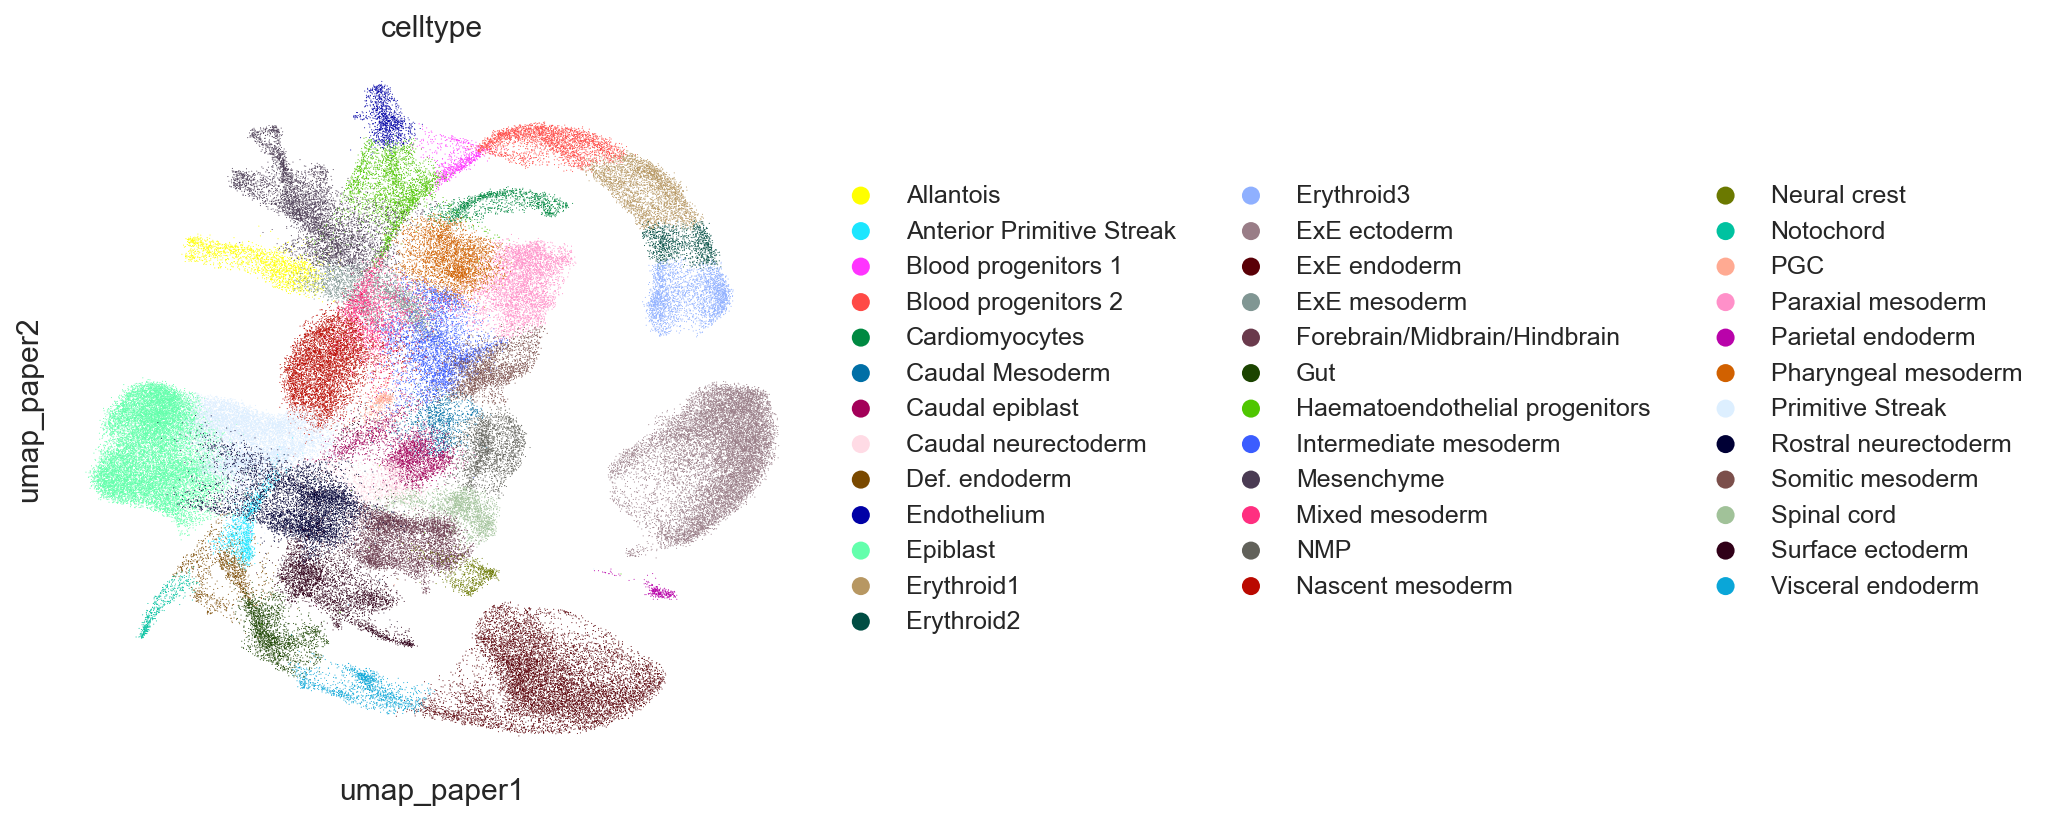

In [6]:
sc.pl.scatter(
    rna_ad,
    basis=plbasis,
    color=[
        ct_col,
    ],
    legend_fontsize=12,
    size=1,
)

In [7]:
if "custom_exclude" in exclude.keys():
    rna_ad.obs["custom_exclude"] = (rna_ad.obs[time_col] == "E7.0") & (
        rna_ad.obsm[f"X_{plbasis}"][:, 1] > 18
    )
    rna_ad.obs["custom_exclude"] = (
        rna_ad.obs["custom_exclude"].astype(str).astype("category")
    )


def get_mask(obs):
    ex_masks = pd.DataFrame(
        {col: obs[col].isin(bad_values) for col, bad_values in exclude.items()}
    )
    return ~ex_masks.any(axis=1)

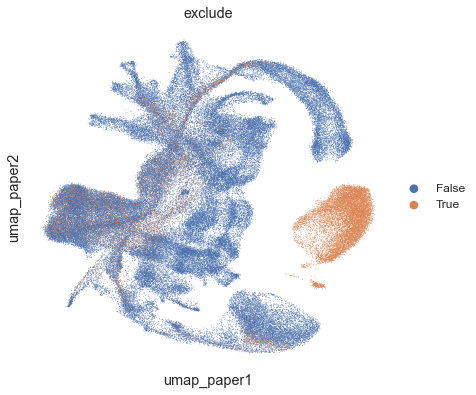

In [8]:
matplotlib.rcParams["figure.dpi"] = 72
matplotlib.rcParams["figure.figsize"] = [6, 6]
mask = get_mask(rna_ad.obs)
rna_ad.obs["exclude_mask"] = ~mask
rna_ad.obs["exclude"] = rna_ad.obs["exclude_mask"].astype("category")
sc.pl.scatter(
    rna_ad,
    basis=plbasis,
    color=[
        "exclude",
    ],
    legend_fontsize=12,
    size=2,
)

In [9]:
ad = rna_ad[mask, :].copy()

In [10]:
ad.obs["colored_celltypes"] = ad.obs[ct_col].copy()
ad.uns["colored_celltypes_colors"] = [
    colmapdict.get(ct, "#DDDDDD") for ct in ad.obs["colored_celltypes"].cat.categories
]

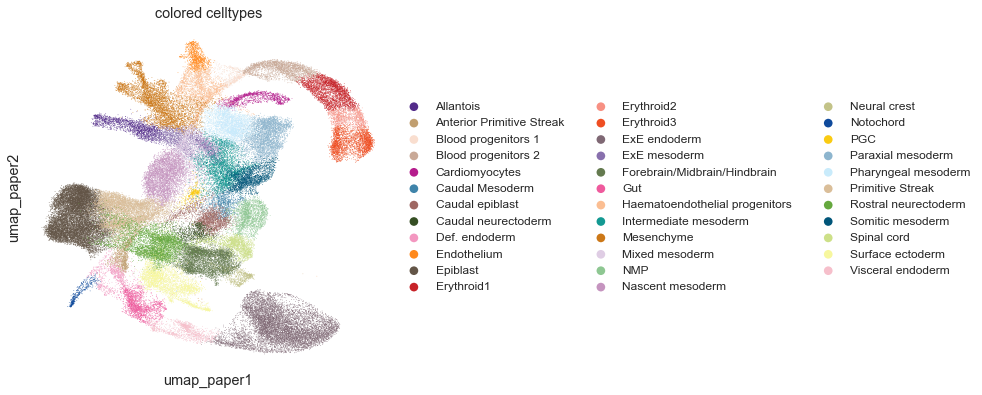

In [11]:
sc.pl.scatter(
    ad,
    basis=plbasis,
    color=[
        "colored_celltypes",
    ],
    legend_fontsize=12,
    size=2,
)

In [12]:
palantir.utils.run_diffusion_maps(ad, n_components=dm_ncomp)
palantir.utils.determine_multiscale_space(ad)
palantir.utils.run_magic_imputation(ad)
palantir.utils.run_local_variability(ad)
ad

Determing nearest neighbor graph...


AnnData object with n_obs × n_vars = 98192 × 16695
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'TP_density', 'custom_exclude', 'exclude_mask', 'exclude', 'colored_celltypes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'hvg', 'neighbors', 'pca', 'stage_colors', 'umap', 'exclude_colors', 'colored_celltypes_colors', 'DM_EigenValues'
    obsm: 'X_pca', 'X_umap', 'X_umap_paper', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data', 'local_variability'
    obsp: 'connectivities', 'distances', 'DM_Kernel', 'DM_Similarity'

Using cell_40791 for cell type Forebrain/Midbrain/Hindbrain which is min in diffusion component 3.
Using cell_38185 for cell type Endothelium which is max in diffusion component 4.
Using cell_97713 for cell type ExE endoderm which is min in diffusion component 0.
Using cell_135924 for cell type Erythroid3 which is max in diffusion component 0.
Using cell_100358 for cell type Cardiomyocytes which is max in diffusion component 2.
Using cell_96402 for cell type Allantois which is max in diffusion component 7.
Using cell_95567 for cell type Notochord which is min in diffusion component 9.
Using cell_43031 for cell type Epiblast which is min in diffusion component 1.


/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/palantir/utils.py:867: UserWarning: No valid component found: Neural crest Consider increasing the number of diffusion components ('n_components' in palantir.utils.run_diffusion_maps). The cell type Neural crest will be skipped.
  warn(


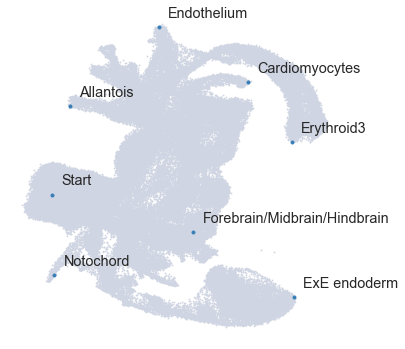

In [13]:
terminal_states = palantir.utils.find_terminal_states(
    ad,
    terminal_celltypes,
    ct_col,
)
early_cell = palantir.utils.early_cell(ad, early_celltype, ct_col)
highlights = terminal_states.copy()
highlights[early_cell] = "Start"
palantir.plot.highlight_cells_on_umap(
    ad,
    highlights,
    s=1,
    embedding_basis=embedding_basis,
)
plt.show()

In [14]:
pr_res = palantir.core.run_palantir(
    ad,
    early_cell,
    terminal_states=terminal_states,
    use_early_cell_as_start=True,
    knn=50,
    num_waypoints=10_000,
)

Sampling and flocking waypoints...
Time for determining waypoints: 7.392696245511373 minutes
Determining pseudotime...
Shortest path distances using 50-nearest neighbor graph...
Time for shortest paths: 25.753679172197977 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [15]:
masks = palantir.presults.select_branch_cells(ad)

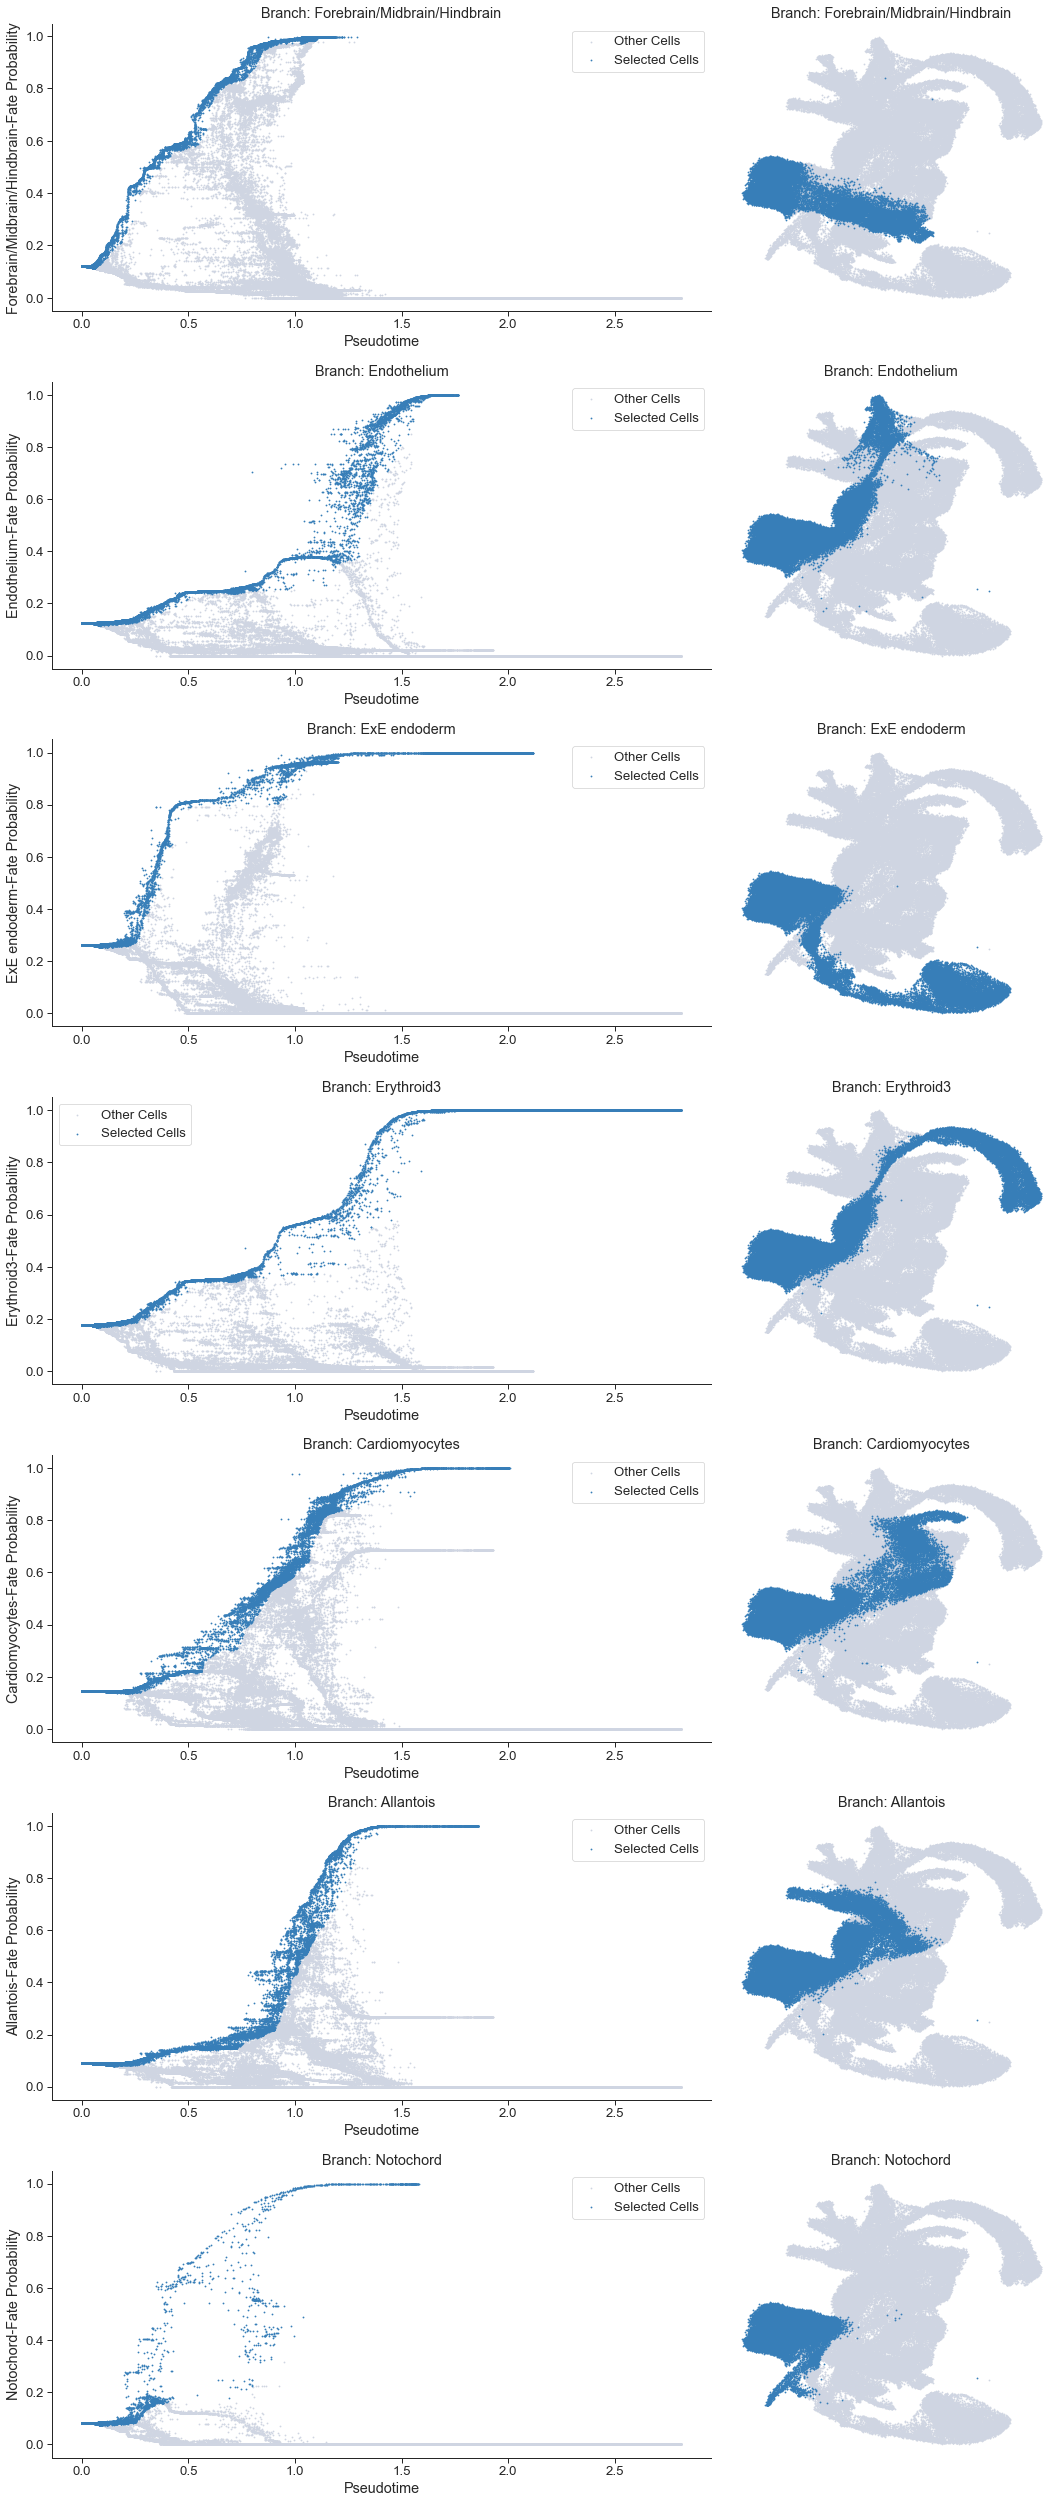

In [16]:
palantir.plot.plot_branch_selection(ad, s=1, embedding_basis=embedding_basis)
plt.show()

In [17]:
ad

AnnData object with n_obs × n_vars = 98192 × 16695
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'TP_density', 'custom_exclude', 'exclude_mask', 'exclude', 'colored_celltypes', 'palantir_pseudotime', 'palantir_entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'hvg', 'neighbors', 'pca', 'stage_colors', 'umap', 'exclude_colors', 'colored_celltypes_colors', 'DM_EigenValues', 'palantir_waypoints'
    obsm: 'X_pca', 'X_umap', 'X_umap_paper', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'palantir_fate_probabilities', 'branch_masks'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data

In [18]:
file_path = os.path.join(out_path, "preprocessed_mouse-gastrulation-atlas.h5ad")
ad.write(file_path)

In [19]:
import pwd
user_info = pwd.getpwuid(os.getuid())
author = user_info.pw_gecos
email = user_info.pw_name + "@fredhutch.org"
%load_ext watermark
%watermark -a "{author}" -e {email} -h -v -iv -m -u -w -i

Author: Dominik Otto, S2-106, x4475,umask=0007, Setty Lab,

Email: dotto@fredhutch.org

Last updated: 2023-06-23T01:02:16.311159-07:00

Python implementation: CPython
Python version       : 3.10.10
IPython version      : 8.13.2

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 4.15.0-192-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 36
Architecture: 64bit

Hostname: gizmok125

pandas    : 1.5.3
scanpy    : 1.9.3
matplotlib: 3.7.1
palantir  : 1.2

Watermark: 2.3.1

